In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True

import statsmodels.stats.weightstats as wsts

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [2]:
df = pd.read_csv('data/credit_card_default_analysis.csv')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
- a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

#### Визуальная и точечная оценка

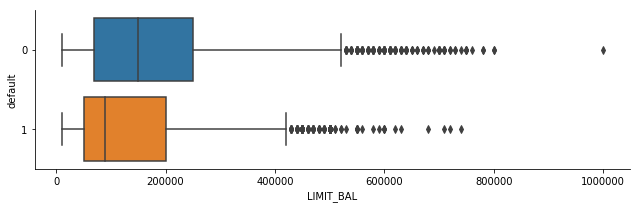

In [25]:
sns.catplot(data=df, x='LIMIT_BAL', y='default',
            kind='box', height=3, aspect=3,
            orient='h');

In [4]:
default0_lim = df[df.default == 0]['LIMIT_BAL']
default1_lim = df[df.default == 1]['LIMIT_BAL']

Оценим точечено. Видим, что в среднем кредитный лимит, у тех кто отдал кредит, был выше на 60к чем у тех, кто не отдал.

In [26]:
print('Median limit balance difference',
      np.median(default0_lim) - np.median(default1_lim))

Median limit balance difference 60000.0


Чтобы построить интервальную оценку среднего, взглянем на распределения признака. Из гистограм видно, что распределение похоже на Пуассоновское, однако мы не уверены в этом, поэтому воспользуемся бустрапированной выборкой для интервальной оценки разности медиан выборок. Бустрап, благодаря своей универсальности позволяет делать оценки на неизвестных нам распределениях.

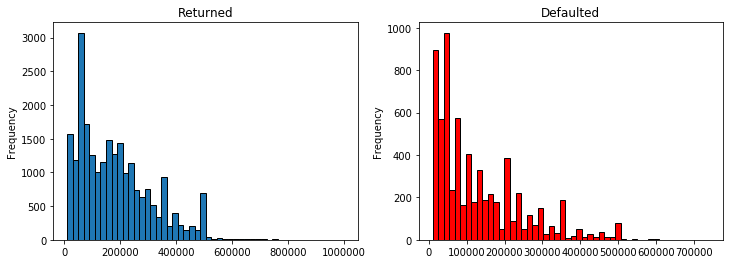

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(121)
df[df.default==0].LIMIT_BAL.plot(kind='hist', bins=50);
plt.title('Returned')
plt.subplot(122)
df[df.default==1].LIMIT_BAL.plot(kind='hist', bins=50, color='r');
plt.title('Defaulted');

In [32]:
def get_bootstrap_samples(data, n_samples):
    ints = np.random.randint(0, len(data), size=(n_samples, len(data)))
    return np.asarray(data)[ints]

In [33]:
def tolerance_int(stat, alpha):
    return np.percentile(stat, [100*alpha/2, 100*(1-alpha/2)])

In [34]:
default0_lim_boot = get_bootstrap_samples(default0_lim, 25000)
default1_lim_boot = get_bootstrap_samples(default1_lim, 25000)

In [35]:
default0_lim_med_scores = np.apply_along_axis(np.median, 1, default0_lim_boot)
default1_lim_med_scores = np.apply_along_axis(np.median, 1, default1_lim_boot)

In [36]:
def0_def1_lim_med_diffs = default0_lim_med_scores - default1_lim_med_scores

Как видно из интервальной оценки, в среднем у тех, кто отдаёт кредит кредитный лимит на 60000-70000 тысяч больше

In [37]:
tolerance_int(def0_def1_lim_med_diffs, 0.05)

array([60000., 70000.])

Проверим гипотезу о равенстве распределений с помощью непараметрического критерия знаковых рангов Уилкоксона-Манна-Уитни

In [38]:
 sc.stats.mannwhitneyu(default0_lim, default1_lim, alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Перестановочный критерий для несвязанных выборок

In [39]:
import permutation_criteria

In [41]:
import importlib

In [44]:
importlib.reload(permutation_criteria)

<module 'permutation_criteria' from '/Users/artem/pyprojects/mldaspec/course4/notebooks/permutation_criteria.py'>

In [ ]:
permutation_criteria.permutation_test_2sample_ind(default0_lim, default1_lim)

In [110]:
wsts.zconfint(df[df.default == 0]['LIMIT_BAL'])

(176411.91449742022, 179787.53765118445)

In [111]:
wsts.zconfint(df[df.default == 1]['LIMIT_BAL'])

(127333.65333983443, 132885.65949922524)

In [122]:
ds0 = wsts.DescrStatsW(df[df.default == 0]['LIMIT_BAL'])
ds1 = wsts.DescrStatsW(df[df.default == 1]['LIMIT_BAL'])

In [124]:
tmeans = wsts.CompareMeans(ds0, ds1)
tmeans.ttest_ind(usevar='unequal')

(28.951587933509845, 3.364100245511471e-178, 11982.127342636823)

In [116]:
ds = wsts.DescrStatsW(df[df.default == 0])

In [121]:
ds.tconfint_mean()

(array([1.49535301e+04, 1.76411827e+05, 1.60790756e+00, 1.83099158e+00,
        1.55195896e+00, 3.53008650e+01, 1.89208338e-01, 1.72336728e-01,
        1.75227178e-01, 1.42324485e-01, 1.15077502e-01, 1.26527007e-01,
        5.10507257e+04, 4.88066032e+04, 4.66411690e+04, 4.27863144e+04,
        3.97531370e+04, 3.82786844e+04, 6.07633340e+03, 6.31600866e+03,
        5.51390456e+03, 5.08651267e+03, 5.04212981e+03, 5.47838569e+03,
        0.00000000e+00]),
 array([1.51762579e+04, 1.79787625e+05, 1.62039239e+00, 1.85168262e+00,
        1.56531548e+00, 3.55336668e+01, 2.03275826e-01, 1.88217971e-01,
        1.91062841e-01, 1.56939339e-01, 1.28373961e-01, 1.40208141e-01,
        5.29377289e+04, 5.06282681e+04, 4.84255622e+04, 4.44360161e+04,
        4.13077537e+04, 3.98058530e+04, 6.53834131e+03, 6.96492149e+03,
        5.99308910e+03, 5.51454596e+03, 5.45431078e+03, 5.96035785e+03,
        0.00000000e+00]))

In [123]:
ds0.tconfint_mean()

(176411.82705267423, 179787.62509593045)

In [144]:
x = np.linspace(pois.ppf(0.05),pois.ppf(0.95),100)
pois = sc.stats.poisson(3)

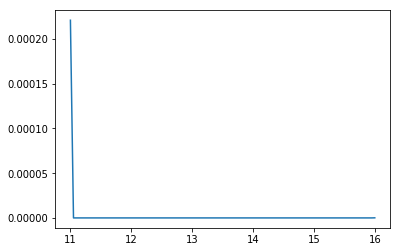

In [149]:
plt.plot(x, pois.pmf(x))

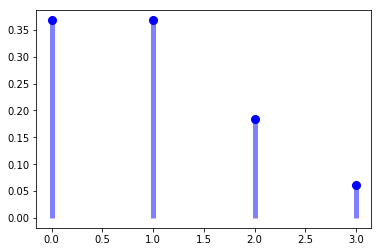

In [159]:
mu=1
fig, ax = plt.subplots(1, 1)
x = np.arange(sc.stats.poisson.ppf(0.01, mu),
              sc.stats.poisson.ppf(0.99, mu))
ax.plot(x, sc.stats.poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, sc.stats.poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)